# Corrective Retrieval Augmented Generation

Going to create a Wikipedia document search.

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv

In [2]:
load_dotenv(Path.cwd().parent / ".env")

True

## Import embeddings

In [3]:
from langchain_openai import OpenAIEmbeddings
openai_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

## Get Wikipedia data

In [4]:
import gzip
import json
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [5]:
wikipedia_filepath = "../datasets/simplewiki-2020-11-01.jsonl.tar.gz"

In [6]:
# start chunking
docs = []
with gzip.open(wikipedia_filepath, 'rt', encoding='utf8') as fIn:
    for line in fIn:
        data = json.loads(line.strip())
        docs.append({
            "metadata": {
                "title": data.get("title"),
                "article_id": data.get("id")
            },
            "data": ' '.join(data.get("paragraphs")[0:3])
        })
# to run things faster get a subset of docs
docs = [doc for doc in docs for x in ['india'] if x in doc["data"].lower().split()]
# create docs object
docs = [Document(
    page_content=doc["data"],
    metadata=doc["metadata"]
) for doc in docs]
# chunk
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=300)
chunked_docs = splitter.split_documents(docs)

In [7]:
len(chunked_docs)

1322

In [8]:
chunked_docs[:3]

[Document(metadata={'title': 'Basil', 'article_id': '73985'}, page_content='Basil ("Ocimum basilicum") ( or ) is a plant of the Family Lamiaceae. It is also known as Sweet Basil or Tulsi. It is a tender low-growing herb that is grown as a perennial in warm, tropical climates. Basil is originally native to India and other tropical regions of Asia. It has been cultivated there for more than 5,000 years. It is prominently featured in many cuisines throughout the world. Some of them are Italian, Thai, Vietnamese and Laotian cuisines. It grows to between 30–60\xa0cm tall. It has light green, silky leaves 3–5\xa0cm long and 1–3\xa0cm broad. The leaves are opposite each other. The flowers are quite big. They are white in color and arranged as a spike. The plant tastes somewhat like anise, with a strong, pungent, sweet smell. Basil is very sensitive to cold. It is best grown in hot, dry conditions. While most common varieties are treated as annuals, some are perennial, including African Blue a

## Create a Vector DB and persist on disk

In [9]:
from langchain_chroma import Chroma

In [10]:
# create a vector db
chroma_db = Chroma.from_documents(
    documents=chunked_docs,
    collection_name='rag_wikipedia_db',
    embedding=openai_embeddings,
    collection_metadata={"hnsw:space": "cosine"},
    persist_directory="../wikipedia_db"
)

### Define a retrieval

In [11]:
similarity_threshold_retriever = chroma_db.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={
        "k": 3,
        "score_threshold": 0.3
    }
)

In [12]:
# test the rertriever
query = "What is the capital of India?"
top_k_docs = similarity_threshold_retriever.invoke(query)
top_k_docs

[Document(metadata={'article_id': '5117', 'title': 'New Delhi'}, page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7\xa0km. New Delhi has a population of about 9.4 Million people.'),
 Document(metadata={'article_id': '5117', 'title': 'New Delhi'}, page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7\xa0km. New Delhi has a population of about 9.4 Million people.'),
 Document(metadata={'article_id': '5117', 'title': 'New Delhi'}, page_content='New Delhi () is the capital of India and a union terr

In [13]:
# another test
query = "What is langgraph?"
top_k_docs = similarity_threshold_retriever.invoke(query)
print(top_k_docs)

# so as see the retriver has not the hability to answer this particular question cause the data
# ingested has no information about langgraph. In this case need to grade either the reponse is
# valid or not

[Document(metadata={'article_id': '123162', 'title': 'Lubanki'}, page_content='Lubanki, also known as Labanki, is an Indo-Aryan language spoken by the Lubanas tribal grouping in the Republic of India and Pakistan. It is classified as a form or dialect of Punjabi. Lubanki has been spoken in the Rajasthan and Gujarat areas and some areas of Pakistan. The Punjabi word tanda is allegedly of Lubanki origin and means a town. The dialect is almost extinct. With the loss of the language\'s prestige and status, most Lubanas now speak other forms of Punjabi as their primary language. When Guru Tegh Bahadur Was discovered by Baba Makhan Shah Labana, Makhan Shah climbed on top a village roof and started shouting the famous line Guru ladho rae "The Guru has been found", which is alleged to be in Lubanki dialect.'), Document(metadata={'article_id': '123162', 'title': 'Lubanki'}, page_content='Lubanki, also known as Labanki, is an Indo-Aryan language spoken by the Lubanas tribal grouping in the Repub

In [14]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

In [15]:
# Now create the query retrieval grader
class GradeDocuments(BaseModel):
    """
    Binary score for relevance check on retrieved documents
    """
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

In [16]:
# define LLM to be the grader
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [17]:
# now define roles
SYS_PROMPT = """
    You are an expert grader assessing relevance of a retrieved document to a user question.
    Follow these instructions for grading:
        - If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
        - Your grade should be either 'yes' or 'no' to indicate whether the document is relevant to the question or not. 
"""
prompt = """
    Retrieved document:
    {document}

    User question:
    {question}
"""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", prompt)
    ]
)
# build grader chain
doc_grader = (grade_prompt | structured_llm_grader)

In [18]:
# test it
query = "What is the capital of India?"
top_k_docs = similarity_threshold_retriever.invoke(query)
for doc in top_k_docs:
    print(doc.page_content)
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7 km. New Delhi has a population of about 9.4 Million people.
GRADE: binary_score='yes'

New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7 km. New Delhi has a population of about 9.4 Million people.
GRADE: binary_score='yes'

New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian 

In [19]:
# Again with the langgraph question
query = "What is langgraph?"
top_k_docs = similarity_threshold_retriever.invoke(query)
for doc in top_k_docs:
    print(doc.page_content)
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

Lubanki, also known as Labanki, is an Indo-Aryan language spoken by the Lubanas tribal grouping in the Republic of India and Pakistan. It is classified as a form or dialect of Punjabi. Lubanki has been spoken in the Rajasthan and Gujarat areas and some areas of Pakistan. The Punjabi word tanda is allegedly of Lubanki origin and means a town. The dialect is almost extinct. With the loss of the language's prestige and status, most Lubanas now speak other forms of Punjabi as their primary language. When Guru Tegh Bahadur Was discovered by Baba Makhan Shah Labana, Makhan Shah climbed on top a village roof and started shouting the famous line Guru ladho rae "The Guru has been found", which is alleged to be in Lubanki dialect.
GRADE: binary_score='no'

Lubanki, also known as Labanki, is an Indo-Aryan language spoken by the Lubanas tribal grouping in the Republic of India and Pakistan. It is classified as a form or dialect of Punjabi. Lubanki has been spoken in the Rajasthan and Gujarat areas

## Create a QA RAG Chain

In [20]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

In [21]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [22]:
prompt = """
    You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question.
    If no context is present or if you don't know the answer, just say that you don't know the answer.
    Do not make up the answer unless it is there in the provided context.
    Give a detailed answer and to the point answer with regard to the question.

    Question:
    {question}

    Context:
    {context}

    Answer:
"""
prompt_template = ChatPromptTemplate.from_template(prompt)
chat_model = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)
# define the RAG chain passing context and functions to run
qa_rag_chain = (
    {
        "context": (itemgetter("context") | RunnableLambda(format_docs)),
        "question": itemgetter("question")
    }
    | prompt_template
    | chat_model
    | StrOutputParser()
)

In [23]:
# test it. Now it prints only the relevant answer from documents retrieved
query = "What is the capital of India?"
top_k_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke({"context": top_k_docs, "question": query})
print(result)

The capital of India is New Delhi. It is also a union territory within the megacity of Delhi. New Delhi has a rich history and is known for its numerous monuments. The city is characterized by a high cost of living and falls under the North Indian geographical zone. It covers an area of approximately 42.7 square kilometers and has a population of about 9.4 million people.


In [24]:
# With this QA approach, the model does not come up with an answer for the langgraph question.
# cause the retrieved documents has no data relevant to the question
query = "What is langchain?"
top_k_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke({"context": top_k_docs, "question": query})
print(result)

No relevant docs were retrieved using the relevance score threshold 0.3


I don't know the answer.


## Create a Query Rephraser
It maybe that the answer is not relevant due to the quality of the user query. Then let's create a query rephraser to make it more accurate.

In [25]:
# define an LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

# Prompt template for rewriting
SYS_PROMPT = """
    Act as a question re-writer and perform the following task:
    - Convert the following input question to a better version that is optimized for web search.
    - When re-writing, look at the input question and try to reason about the underlying semantic intent / meaning.
"""
prompt = """
    Here is the initial question:
    {question}

    Formulate an improved question.
"""
# now create a re-write prompt
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", prompt)
    ]
)
# chain
question_rewriter = (re_write_prompt | llm | StrOutputParser())

In [26]:
query = "What is langchain?"
question_rewriter.invoke({"question": query})

'What is LangChain and how is it used in programming?'

## Load web search tool
Now start creating tools for those cases the retrieval information does not match the query.

In [27]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [28]:
tv_search = TavilySearchResults(max_results=3, search_depth="advanced", max_tokens=1e5)

### Build agentic RAG components

In [29]:
from typing import List
from typing_extensions import TypedDict

In [30]:
# define a graph agentic structure
class GraphState(TypedDict):
    question: str
    generation: str
    web_search_needed: str
    documents: List[str]

In [31]:
# define a function to retrieve documents from vector db
def retrieve(state):
    print("---Retrival form vector DB---")
    question = state["question"]
    
    # retrieve documents from vector db
    documents = similarity_threshold_retriever.invoke(question)
    return {"documents": documents, "question": question}

In [32]:
# define another function to grade retrieved documents
def grade_documents(state):
    print("---Checking document revelance question---")
    question = state["question"]
    documents = state["documents"]

    # score each doc
    filtered_docs = []
    web_search_needed = "no"
    if documents:
        for d in documents:
            score = doc_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score.binary_score
            if grade == "yes":
                print("---Grade: docuement relevant---")
                filtered_docs.append(d)
            else:
                print("---Grade: docuement not relevant---")
                web_search_needed = "yes"
    else:
        print("---No documents found---")
        web_search_needed = "yes"
    
    return {"documents": filtered_docs, "question": question, "web_search_needed": web_search_needed}

In [33]:
# once there's a need for web search, it's a good practice to
# re-wrire the query
def rewrite_query(state):
    print("---Rewriting question for web search---")
    question = state["question"]
    documents = state["documents"]
    
    better_query = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_query}

In [34]:
from langchain.schema import Document

In [41]:
# do web search
def web_search(state):
    print("---Web search---")
    question = state["question"]
    documents = state["documents"]

    # do web search
    docs = tv_search.invoke(question)
    web_results = "\n\n".join(doc["content"] for doc in docs)
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

In [35]:
# create a function to decide wether to generate an answer or not
# this is needed to make the graph taking a path or another
def decide_generation(state):
    print("---Assess grade docuements---")
    web_search_needed = state["web_search_needed"]

    if web_search_needed == "yes":
        print("---Some or all documents are irrelevant, rewriting query---")
        return "rewrite_query"
    else:
        print("---Generating answer---")
        return "generate_answer"


In [36]:
# generate answer
def generate_answer(state):
    print("---Generating answer---")
    question = state["question"]
    documents = state["documents"]

    # generate answer
    result = qa_rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": result}

### Build Agent Graph

In [38]:
from langgraph.graph import END, StateGraph

In [44]:
agentic_rag = StateGraph(GraphState)

# define nodes
agentic_rag.add_node("retrieve", retrieve)
agentic_rag.add_node("grade_documents", grade_documents)
agentic_rag.add_node("rewrite_query", rewrite_query)
agentic_rag.add_node("web_search", web_search)
agentic_rag.add_node("generate_answer", generate_answer)

# build answer
agentic_rag.set_entry_point("retrieve")
agentic_rag.add_edge("retrieve", "grade_documents")
agentic_rag.add_conditional_edges(
    "grade_documents",
    decide_generation,
    {
        "rewrite_query": "rewrite_query",
        "generate_answer": "generate_answer"
    }
)
agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer")
agentic_rag.add_edge("generate_answer", END)

# compile
agentic_rag = agentic_rag.compile()

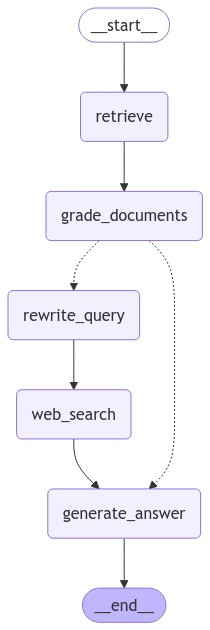

In [46]:
from IPython.display import display, Markdown, Image

display(Image(agentic_rag.get_graph().draw_mermaid_png()))

In [48]:
query = "What's the capital of India?"
response = agentic_rag.invoke({"question": query})

---Retrival form vector DB---
---Checking document revelance question---
---Grade: docuement relevant---
---Grade: docuement relevant---
---Grade: docuement relevant---
---Assess grade docuements---
---Generating answer---
---Generating answer---


In [49]:
display(Markdown(response["generation"]))

The capital of India is New Delhi. It is also a union territory and part of the larger megacity of Delhi. New Delhi has a rich history and is known for its numerous monuments. The city is characterized by a high cost of living and falls within the North Indian geographical zone. It covers an area of approximately 42.7 square kilometers and has a population of about 9.4 million people.

In [50]:
query = "Who won the last USA presidential elections?"
response = agentic_rag.invoke({"question": query})

---Retrival form vector DB---
---Checking document revelance question---
---Grade: docuement not relevant---
---Grade: docuement not relevant---
---Grade: docuement not relevant---
---Assess grade docuements---
---Some or all documents are irrelevant, rewriting query---
---Rewriting question for web search---
---Web search---
---Generating answer---


In [51]:
display(Markdown(response["generation"]))

The most recent U.S. presidential election was held in 2024, and Donald Trump was elected as the 47th President of the United States. The election results indicated that Trump received 249,225 votes (60.2%), while Kamala Harris received 158,810 votes (38.4%).